### Prerequisite

In [1]:
!pip install -q pandarallel
!pip install -q spacy 
!pip install -q spacy_cld
!pip install -q pyspellchecker
!python -m spacy download xx_ent_wiki_sm > /dev/null

### Import libraries and utility scripts

In [2]:
import os
import gc
import spacy
import re
import nltk
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
from nltk import sent_tokenize
from spacy_cld import LanguageDetector
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,Bidirectional,LSTM,Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,Average,Dropout,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from spellchecker import SpellChecker
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from tqdm.notebook import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
warnings.filterwarnings("ignore")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Define config

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE
GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')

# Configuration
EPOCHS = 2 
BATCH_SIZE = 16 * strategy.num_replicas_in_sync #128 batch size
MAX_LEN = 192
MODEL = 'jplu/tf-xlm-roberta-large'

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


### Load datasets

In [4]:
D = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'
O = '/kaggle/input/open-subtitles-toxic-pseudo-labeling/'
V = '/kaggle/input/jigsaw-multilingual-toxic-test-translated/'

train1 = pd.read_csv(D+'jigsaw-toxic-comment-train.csv')
train2 = pd.read_csv(D+'jigsaw-unintended-bias-train.csv')
train2.toxic = train2.toxic.round().astype(int)
valid = pd.read_csv(D+'validation.csv')
test = pd.read_csv(D+'test.csv')
sub = pd.read_csv(D+'sample_submission.csv')
open_subtitle = pd.read_csv(O+'open-subtitles-synthesic.csv')
valid_en = pd.read_csv(V+'jigsaw_miltilingual_valid_translated.csv').rename(columns={"comment_text": "comment_text1", "translated": "comment_text"})

In [5]:
# Combine train1 with a subset of train2
train_org = pd.concat([
     valid_en[['comment_text', 'toxic']].query('toxic==1'),
     valid_en[['comment_text', 'toxic']].query('toxic==0'),
     train1[['comment_text', 'toxic']].query('toxic==1'),
     train1[['comment_text', 'toxic']].query('toxic==0').sample(sum(train1.toxic),random_state=42),
     train2[['comment_text', 'toxic']].query('toxic==1'),
     train2[['comment_text', 'toxic']].query('toxic==0').sample(sum(train2.toxic),random_state=42)
],axis = 0).reset_index(drop=True)
train_org['lang'] = 'en'
train_org = train_org.drop_duplicates(subset='comment_text')
train_org = train_org.sample(frac=1).reset_index(drop=True)
del train1, train2, valid_en
gc.collect()

41

In [6]:
open_subtitle_data = pd.DataFrame()
LANGS=['it','fr','es','tr','ru','pt']
for lang in LANGS:
    ln = "'"+lang+"'"
    open_subtitle_data=open_subtitle_data.append(pd.concat([
        open_subtitle[['comment_text', 'toxic','lang']].query('toxic==0 and lang == '+ln).sample(10000),
        open_subtitle[['comment_text', 'toxic','lang']].query('toxic==1 and lang == '+ln).sample(10000)]))
open_subtitle_data = open_subtitle_data.reset_index(drop=True)

In [7]:
trans = pd.read_csv('../input/jigsaw-train-translated-yandex-api/train_yandex.csv')
trans = trans[['comment_text','toxic','lang']]
yandex_data = pd.DataFrame()
LANGS=['it','fr','es','tr','ru','pt']
for lang in LANGS:
    ln = "'"+lang+"'"
    in_toxic = trans.query('toxic==0 and lang == '+ln).sample(20000)
    toxic = trans.query('toxic==1 and lang == '+ln)
    yandex_data = yandex_data.append(pd.concat([in_toxic,toxic]))
yandex_data = yandex_data.reset_index(drop=True)

In [8]:
train_pop = pd.concat([yandex_data,train_org],axis = 0).reset_index(drop=True)
train_pop = train_pop.sample(frac=1).reset_index(drop=True)
del yandex_data, train_org
gc.collect()

257

In [9]:
train = pd.concat([train_pop,open_subtitle_data],axis = 0).reset_index(drop=True)
train = train.sample(frac=1).reset_index(drop=True)
del train_pop, open_subtitle_data
gc.collect()

20

In [10]:
#In train
print("Train Toxic = ",len( train[['comment_text', 'toxic']].query('toxic==1')))
print("Train Intoxic = ",len(train[['comment_text', 'toxic']].query('toxic==0')))

#In valid
print("Valid Toxic = ",len( valid[['comment_text', 'toxic']].query('toxic==1')))
print("Valid Intoxic = ",len(valid[['comment_text', 'toxic']].query('toxic==0')))

Train Toxic =  256943
Train Intoxic =  319891
Valid Toxic =  1230
Valid Intoxic =  6770


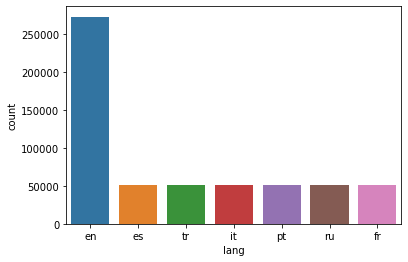

In [11]:
sns.countplot(train['lang'])

In [12]:
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)
save_path = '/kaggle/working/xlmr_large/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)
#tokenizer.tokenize("13,000 people receive evacuation orders in. I am good as agood emvironment.")

('/kaggle/working/xlmr_large/sentencepiece.bpe.model',
 '/kaggle/working/xlmr_large/special_tokens_map.json',
 '/kaggle/working/xlmr_large/added_tokens.json')

In [13]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    return np.array(enc_di['input_ids'])

### Data preparation

In [14]:
%%time 
x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values
del train, valid, test
gc.collect()

CPU times: user 6min 33s, sys: 2.5 s, total: 6min 36s
Wall time: 6min 36s


0

### Build datasets objects

In [15]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [16]:
def label_smoothing(y_true,y_pred):
     return tf.keras.losses.binary_crossentropy(y_true,y_pred,label_smoothing=0.1)

### Load Model

In [17]:
def build_model1(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    apool= GlobalAveragePooling1D()(sequence_output)
    mpol = GlobalMaxPooling1D()(sequence_output)
    cat = concatenate([
        apool,
        mpol
    ])
    x = Dropout(0.3)(cat)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_word_ids, outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
    model.compile(optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    
    return model


def build_model2(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_word_ids, outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    
    return model

# Multi Sample dropout 
def build_model3(transformer, max_len=512):   
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    seq_out = transformer(input_word_ids)[0]
    pool= GlobalAveragePooling1D()(seq_out)
    dense=[]
    FC = Dense(32,activation='relu')
    for p in np.linspace(0.2,0.5,3):
        x=Dropout(p)(pool)
        x=FC(x)
        x=Dense(1,activation='sigmoid')(x)
        dense.append(x)
    
    out = Average()(dense)
    
    model = Model(inputs=input_word_ids, outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
    model.compile(optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    
    return model

### Load model into the TPU

In [18]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model1(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 192)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 192, 1024),  559890432   input_word_ids[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 1024)         0           tf_roberta_model[0][0]           
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 1024)         0           tf_roberta_model[0][0]           
_____________________________________________________________________________________________

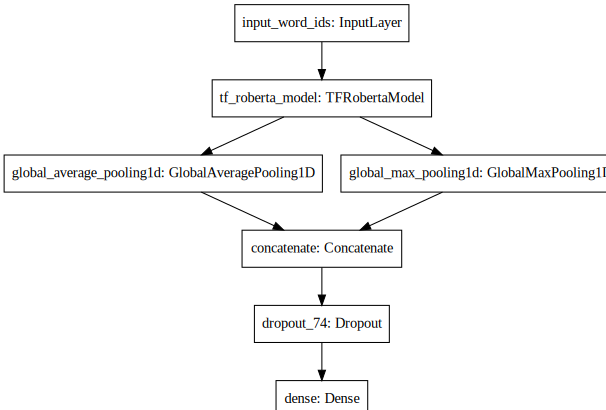

In [19]:
from IPython.display import SVG
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

### Learning rate scheduler

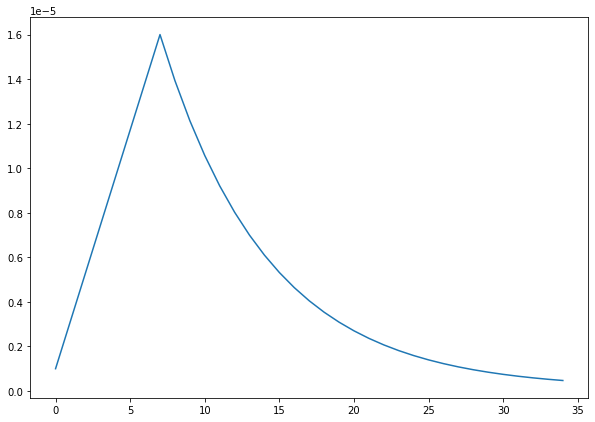

In [20]:
def build_lrfn(lr_start=0.000001, lr_max=0.000002, 
               lr_min=0.0000001, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

plt.figure(figsize=(10, 7))
lrfn = build_lrfn()
plt.plot([i for i in range(35)], [lrfn(i) for i in range(35)]);

In [21]:
filepath = f'/kaggle/working/roberta_large.h5'
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True,save_weights_only=True,mode='max')

In [22]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=2, 
                   restore_best_weights=True, verbose=1)
lr_callback = LearningRateScheduler(lrfn, verbose=1)

callback_list = [checkpoint, lr_callback]

### Train Model

In [23]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callback_list
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/2
4506/4506 [==============================] - ETA: 0s - loss: 0.3609 - auc: 0.9191
Epoch 00001: val_auc improved from -inf to 0.93548, saving model to /kaggle/working/roberta_large.h5
4506/4506 [==============================] - 1906s 423ms/step - loss: 0.3609 - auc: 0.9191 - val_loss: 0.3192 - val_auc: 0.9355 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-06.
Epoch 2/2
4506/4506 [==============================] - ETA: 0s - loss: 0.2253 - auc: 0.9688
Epoch 00002: val_auc improved from 0.93548 to 0.94218, saving model to /kaggle/working/roberta_large.h5
4506/4506 [==============================] - 1868s 415ms/step - loss: 0.2253 - auc: 0.9688 - val_loss: 0.2658 - val_auc: 0.9422 - lr: 3.1429e-06


In [24]:
if os.path.exists(filepath):
    model.load_weights(filepath)

we train it for 2 more epochs on the validation set, which is significantly smaller but contains a mixture of different languages.

In [25]:
%%time
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    callbacks=callback_list,
    epochs= EPOCHS
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/2
62/62 [==============================] - 25s 403ms/step - loss: 0.2180 - auc: 0.9390 - lr: 1.0000e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-06.
Epoch 2/2
62/62 [==============================] - 25s 403ms/step - loss: 0.1968 - auc: 0.9477 - lr: 3.1429e-06
CPU times: user 4.33 s, sys: 819 ms, total: 5.15 s
Wall time: 1min 38s


### Load translated test dataset

In [26]:
df_en1 = pd.read_csv("../input/test-en-df/test_en.csv")
df_en2 = pd.read_csv("../input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_test_translated.csv")
x_test1 = regular_encode(df_en1.content_en.values, tokenizer, maxlen=MAX_LEN)
x_test2 = regular_encode(df_en2.translated.values, tokenizer, maxlen=MAX_LEN)
test_dataset1 = (
    tf.data.Dataset
    .from_tensor_slices(x_test1)
    .batch(BATCH_SIZE)
)
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices(x_test2)
    .batch(BATCH_SIZE)
)

### Submission

In [27]:
en_out =  model.predict(test_dataset,verbose=1)
en_out = np.squeeze(en_out) 
en1 = model.predict(test_dataset1,verbose=1)
en1 = np.squeeze(en1) 
en2 = model.predict(test_dataset2,verbose=1)
en2 = np.squeeze(en2)
sub['toxic'] = (en_out+en1+en2) / 3.0
sub.to_csv('submission.csv', index=False)
sub.head(10)

499/499 [==============================] - 55s 110ms/step


,id,toxic
0,0,0.001597
1,1,0.039853
2,2,0.159767
3,3,0.005037
4,4,0.004312
5,5,0.360957
6,6,0.000837
7,7,0.019141
8,8,0.184217
9,9,0.179278


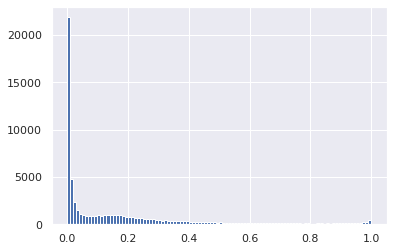

In [28]:
sns.set()
plt.hist(sub['toxic'],bins=100)
plt.show()